# ADCP data starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

Read in the ADCP data.  We'll use Xarray to read the netCDF.

**Note**: to use xarray for reading netCDF files, you will also need the netcdf4 package.  For example, using Conda:

``` console
$ conda install netcdf4
```

The `environment.yaml` file has also been updated.

In [2]:
ADCP_FILE_PATH = 'your path here'  # e.g. './data/T3_NodulePoint_May2010_ADCP_cleaned.nc'
adcp_data = xr.open_dataset(ADCP_FILE_PATH)

In [3]:
adcp_data

<xarray.Dataset>
Dimensions:        (time: 98527, z: 49)
Coordinates:
  * time           (time) float64 7.343e+05 7.343e+05 ... 7.343e+05 7.343e+05
  * z              (z) float64 3.21 3.71 4.21 4.71 ... 25.71 26.21 26.71 27.21
Data variables:
    beam1vel       (time, z) float64 ...
    beam2vel       (time, z) float64 ...
    beam3vel       (time, z) float64 ...
    beam4vel       (time, z) float64 ...
    horizontalvel  (time, z) float64 ...
    direction      (time, z) float64 ...
    depth          (time) float64 ...

Variables in Xarray Datasets are accessed similarly to DataFrames, except metadata is carried around with each variable:

In [4]:
adcp_data['horizontalvel']

<xarray.DataArray 'horizontalvel' (time: 98527, z: 49)>
[4827823 values with dtype=float64]
Coordinates:
  * time     (time) float64 7.343e+05 7.343e+05 ... 7.343e+05 7.343e+05
  * z        (z) float64 3.21 3.71 4.21 4.71 5.21 ... 25.71 26.21 26.71 27.21

The underlying numpy arrays can be accessed using `.values`.  This is required for some functions which do not natively operate on Xarray's DataArrays.

In [5]:
adcp_data['horizontalvel'].values

array([[0.65 , 0.269, 0.886, ...,   nan,   nan,   nan],
       [0.883, 0.705, 0.885, ...,   nan,   nan,   nan],
       [0.911, 1.229, 1.039, ...,   nan,   nan,   nan],
       ...,
       [1.052, 0.607, 1.038, ...,   nan,   nan,   nan],
       [0.99 , 0.767, 0.914, ...,   nan,   nan,   nan],
       [1.034, 0.996, 0.79 , ...,   nan,   nan,   nan]])

Convert MATLAB datenums to Timestamps

In [6]:
unix_epoch = 719529  # Integer corresponding to Unix epoch start (1970-01-01)
adcp_data['time'] = pd.to_datetime(adcp_data['time'] - unix_epoch, unit='D')

Plot horizontal velocity as a function of both time and depth


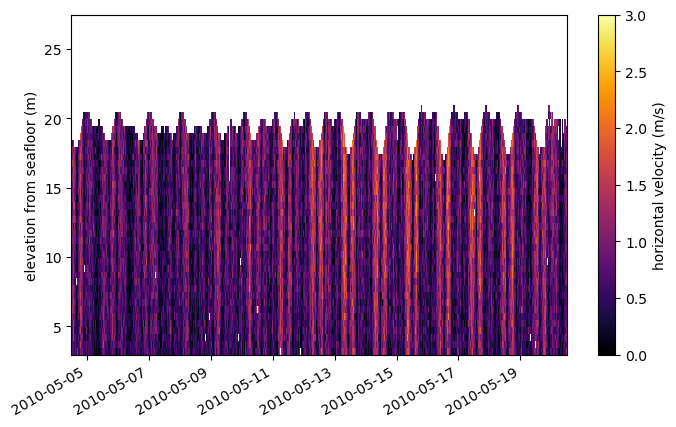

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pcm = ax.pcolormesh(
    adcp_data['time'],
    adcp_data['z'],
    adcp_data['horizontalvel'].T,
    shading='auto',
    cmap='inferno',
    vmin=0,
    vmax=3,
)
cbar = plt.colorbar(pcm)
cbar.set_label('horizontal velocity (m/s)')
ax.set_ylabel('elevation from seafloor (m)')
fig.autofmt_xdate()


Select a single depth bin to compute a binned average in time.

In [8]:
bin_number = 1
horizontal_vel_bin = adcp_data['horizontalvel'].isel(z=bin_number)

print(f'Bin {bin_number} is at {horizontal_vel_bin['z'].values.round(3)} m.')

Bin 1 is at 3.71 m.


There are a number of ways to compute bin averages.  A common approach is to reshape an array of length `m` into several arrays or windows of size `n` and then average each window.  There should be approximately `m/n` windows.  In the event that the length of the array is not divisible by `n`, the array must first be padded.  The following code is adapted from:
https://stackoverflow.com/questions/41815361/average-every-x-numbers-in-numpy-array

In [9]:
def binned_average(arr, n):
    """ Bin an array into windows of size `n` and average each window. """
    # pad array to a multiple of `n` using nan
    xp = np.r_[arr, np.nan + np.zeros((-len(arr) % n,))]
    # reshape into `n` rows (each window) and average across windows
    return np.nanmean(xp.reshape(-1, n), axis=-1)

We need to bin both horizontal velocity and time.  Since the numpy functions generally do not work with timestamps, we first need to convert it to a float, compute the binned average, and then convert the averaged times back to a timestamp.  The average times represent the time at center of each bin.

Example using a window length of 8 s:

In [10]:
sampling_frequency = 2  # Hz (samples/s)
window_length = 8  # s
n = sampling_frequency * window_length  # number of samples in each window

horizontal_vel_bin_averaged = binned_average(horizontal_vel_bin, n)
time_averaged = binned_average(pd.to_numeric(adcp_data['time'].values), n)
time_averaged = pd.to_datetime(time_averaged)

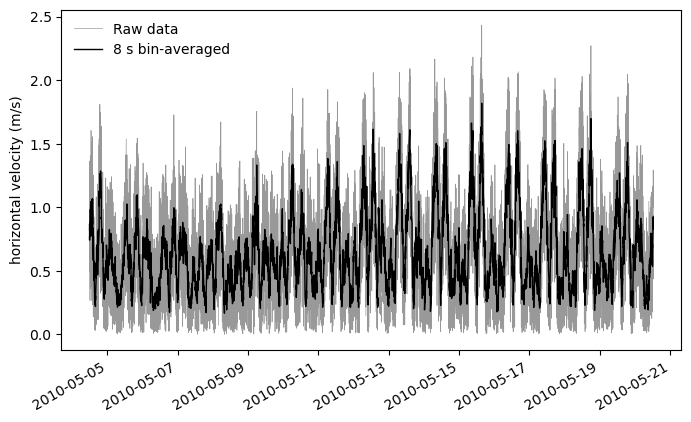

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(
    adcp_data['time'],
    horizontal_vel_bin,
    color='k',
    label='Raw data',
    alpha=0.4,
    linewidth=0.5
)
ax.plot(
    time_averaged,
    horizontal_vel_bin_averaged,
    color='k',
    label=f'{window_length} s bin-averaged',
    linewidth=1
)
ax.set_ylabel('horizontal velocity (m/s)')
fig.autofmt_xdate()
ax.legend(frameon=False)